In [1]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import random

from hopfield_network import HopfieldNetwork
from lippmann_exemplars import LippmanExemplars
from random_exemplars import RandomExemplars

----

**Experiment 1: Successful digit exemplar retrieval from Hopfield networks**

The usefulness of trained Hopfield Network hinges largely on the ability of the network to recall one of the exemplars $p$ on which it was trained when supplied a noisy variant $p^{\prime}$. This recollection of an exemplar happens by first imposing the noisy varient $p^{\prime}$ on the network to obtain an initial output, then (re)imposing that output and each subsequent output iteratively on the network until output no longer changes, having converged to a fixed point in the system - the expected exemplar $p$.

Imposing the noisy input patterns on the network to recall an exemplar can occur synchronously or asynchronously. The former requires that for a timestep $t$ in the iteration,  each neuron in the network is activated simultaneously using the output produced from iteration $t-1$, typically accomplished through a simple matrix multiplication operation: ###TODO: Add details
//OLD content
applying the formula $x_{k+1} = F_{h}(\textbf{W}x_{k})$ iteratively through $k=[0, n]$, where:
- $x_k = p^{\prime}$ when $k = 0$
- $n$ is chosen somewhat arbitrarily, but generally large enough to ensure $x_{k=n}$ represents the exemplar $p$ we aim to retrieve _OR_ the network is stuck in a cycle, thus incapable of retrieving the exemplar at all.
- $F_{h}$ is the hard limiting function, defined as 
- $\textbf{W}$ is the weights matrix of the Hopfield Network


Unfortunately, the synchronous approach is not without limitations. It provides no strong gaurantee of converging to a single output and may instead cycle through multiple output patterns repeatedly. It would be preferable then to use a modality that does create convergence so that we can readily identify a _final_ output of the network from which we can evaluate if it successfully recovered the exemplar we expected.  Asynchronous updating has been proven to result in this converage (citation - Lippmann). It executes as follows:
## TODO: Describe asynchronous execution


With our methodology for recalling exemplars established lets move on to our experiment. Here we will evaluate the ability to recover exemplars from a Hopfield network trained under the Hebbian & Storkey learning rules. The exemplars we have chosen are from the Lippmann paper (citation) as they were created by hand with the intent to exemplify the a Hopfield Network's ability to recall exemplars.  The exemplars consist of 8 patterns covering the digits 0, 1, 2, 3, 4, 6 and 9, with an additional pattern being a simple block. By observation, you can see that some patterns have significant overlap - such as the rightmost strokes for 2, 3 & 4 - while other patterns are distinctly seperate - such as the block & 1:



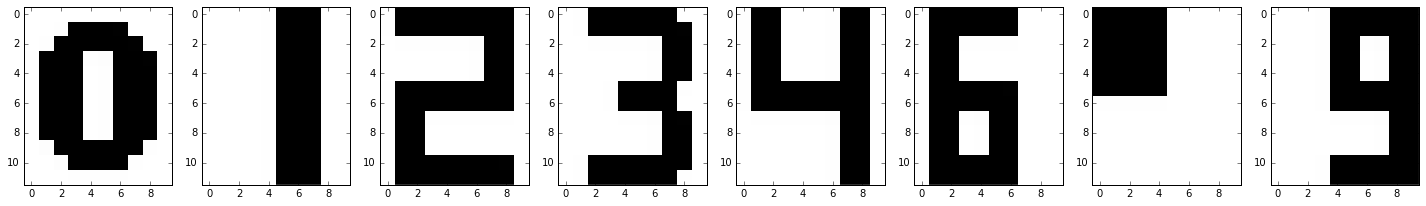

In [2]:
exemplars = LippmanExemplars.get_exemplars()

figure = plt.figure(figsize=(25,20))
cols = len(exemplars)
for i in range(0, len(exemplars)):
    axes = figure.add_subplot(1, cols, i+1)
    axes.imshow(LippmanExemplars.to_matrix(exemplars[i]), cmap='Greys', interpolation='None')

With our exemplars chosen, our experiment will look at what happens when we train a Hopfield Network under the Hebbian Learning rule, then attempt to recall each exemplar when imposing on the network a noisy varient.  We'll continue to replicate Lippmann's example by using the same methodology to generate the noisy exemplar - randomly switching the elements of the exemplar with a probability of _P(switch) = .25_. 

Lets start with a single iteration of recall attempts for all the exemplars.

Number of neurons:120
Capacity: 12.5326586914


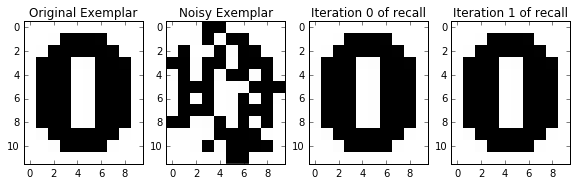

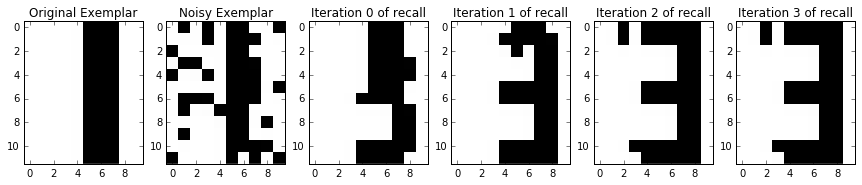

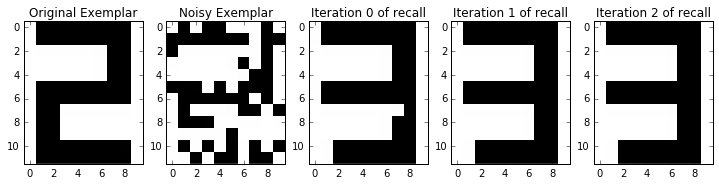

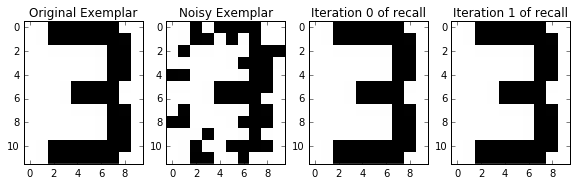

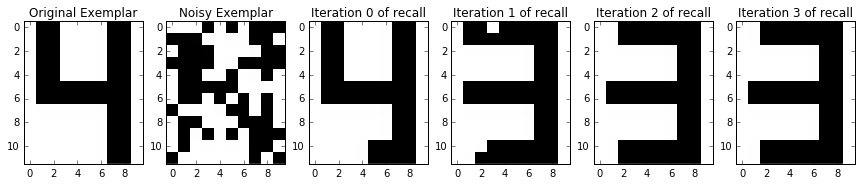

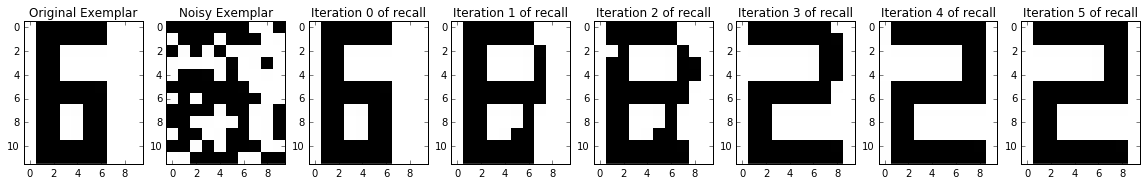

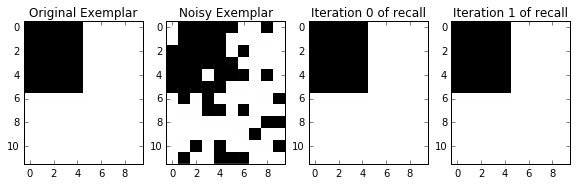

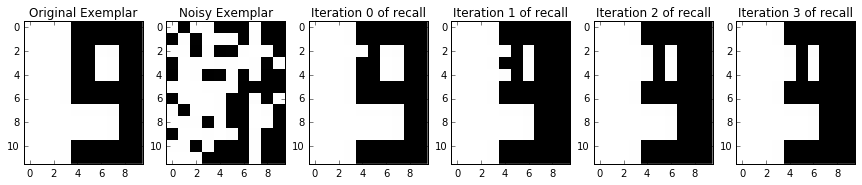

In [3]:
random.seed(123123)
exemplars = LippmanExemplars.get_exemplars()[0:8]
network = HopfieldNetwork(exemplars, learning_rule="Hebb")

print "Number of neurons:{0}".format(network.num_neurons)
print "Capacity: {0}".format(network.capacity)

for exemplar in exemplars:
    noisy_exemplar = LippmanExemplars.add_noise(exemplar, p=.25)
    results = network.asynchronous_recall(noisy_exemplar)

    figure = plt.figure(figsize=(20,20))
    cols = 8

    # Plot original version
    axes = figure.add_subplot(1, cols, 1)
    axes.set_title("Original Exemplar")
    axes.imshow(LippmanExemplars.to_matrix(exemplar), cmap='Greys', interpolation='None')
    
    # Plot noisy version
    axes = figure.add_subplot(1, cols, 2)
    axes.set_title("Noisy Exemplar")
    axes.imshow(LippmanExemplars.to_matrix(noisy_exemplar), cmap='Greys', interpolation='None')
    
    for i, result in enumerate(results):
        axes = figure.add_subplot(1, cols, i + 3)
        axes.imshow(LippmanExemplars.to_matrix(result), cmap='Greys', interpolation='None')
        axes.set_title("Iteration {0} of recall".format(i))
        
    

As we can see from the results, the exemplars for 0, 3 and square block are successfully recovered.  However, the exemplars for 1, 2 and 4 return corrupted versions of the exemplar 3 because of considerable overlap in the digits.  The exemplar for 6 gravitates to 2.  The exemplar returned for 9 is clearly close, but not the original 9.

The successful recovery of the training exemplar is in part dependent on the noise introduced in the noisy varient and the degree to which that noise might have shifted the noisy exemplar towards one of the other exemplars in the training set. We can therefore minimize the impact of variation in the noise by repeatedly running the experiment as a series of trials where the network is trained, a noisy varient of each exemplar generated and imposed on it, and the recalled exemplar evaluated to determine if it is the expected exemplar or not.  We'll run this trial 100 times and calculate and _error rate_ for the recovery of each exemplar:

In [4]:
random.seed(123123)
exemplars = LippmanExemplars.get_exemplars()[0:8]
network = HopfieldNetwork(exemplars, learning_rule="Hebb")

hebbian_error_rates = []
for i, exemplar in enumerate(exemplars):
    errors = 0
    for _ in range(0, 100):
        noisy_exemplar = LippmanExemplars.add_noise(exemplar, p=.25)
        p = network.asynchronous_recall(noisy_exemplar)[-1]
        if p != exemplar:
            errors += 1
    rate = (1.0 * errors) / 100
    print "Error rate for exemplar: {0} was {1}%".format(i, rate * 100)
    hebbian_error_rates.append(rate)
    
m = (1.0 * sum(hebbian_error_rates)) / len(hebbian_error_rates)
print "Mean error rate: {0}%".format(m * 100)

Error rate for exemplar: 0 was 27.0%
Error rate for exemplar: 1 was 100.0%
Error rate for exemplar: 2 was 46.0%
Error rate for exemplar: 3 was 52.0%
Error rate for exemplar: 4 was 100.0%
Error rate for exemplar: 5 was 100.0%
Error rate for exemplar: 6 was 50.0%
Error rate for exemplar: 7 was 100.0%
Mean error rate: 71.875%


Now we'll repeat the experiment after training the Network using the Storkey Learning rule. 

Number of neurons:120
Capacity: 38.7803950852


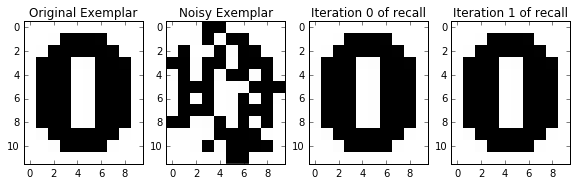

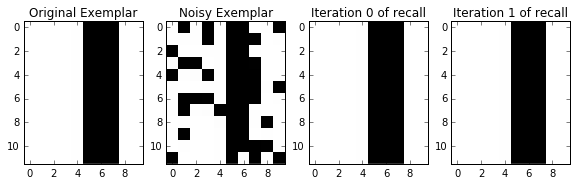

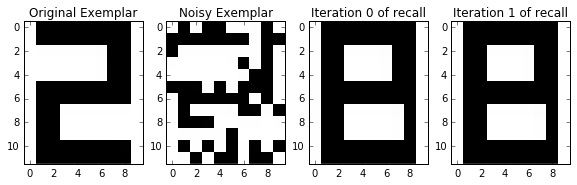

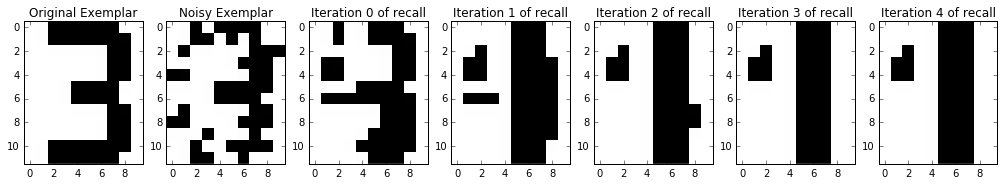

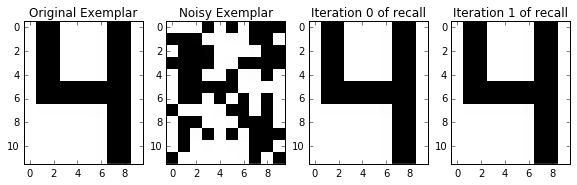

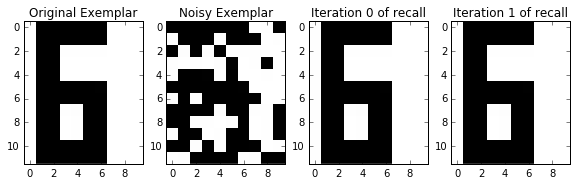

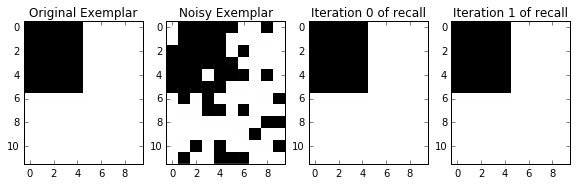

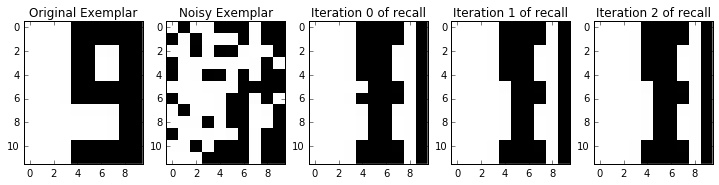

In [5]:
random.seed(123123)
exemplars = LippmanExemplars.get_exemplars()[0:8]
network = HopfieldNetwork(exemplars, learning_rule="Storkey")

print "Number of neurons:{0}".format(network.num_neurons)
print "Capacity: {0}".format(network.capacity)


for exemplar in exemplars:
    noisy_exemplar = LippmanExemplars.add_noise(exemplar, p=.25)
    results = network.asynchronous_recall(noisy_exemplar)

    # output results of recall
    figure = plt.figure(figsize=(20,20))
    cols = 8
    
    # Original version
    axes = figure.add_subplot(1, cols, 1)
    axes.set_title("Original Exemplar")
    axes.imshow(LippmanExemplars.to_matrix(exemplar), cmap='Greys', interpolation='None')
    
    # Noisy version
    axes = figure.add_subplot(1, cols, 2)
    axes.set_title("Noisy Exemplar")
    axes.imshow(LippmanExemplars.to_matrix(noisy_exemplar), cmap='Greys', interpolation='None')
    
    for i, result in enumerate(results):
        axes = figure.add_subplot(1, cols, i + 3)
        axes.imshow(LippmanExemplars.to_matrix(result), cmap='Greys', interpolation='None')
        axes.set_title("Iteration {0} of recall".format(i))

A number of our exemplars have improved recall.  We can see 0, 1, 4, 6, and the block exemplar are recovered successfully from the noisy varient. 

Lets followup by repeating our trials determine the error rates for each exemplar:

In [6]:
random.seed(123123)
exemplars = LippmanExemplars.get_exemplars()[0:8]
network = HopfieldNetwork(exemplars, learning_rule="Storkey")

storkey_error_rates = []
for i, exemplar in enumerate(exemplars):
    errors = 0
    for _ in range(0, 100):
        noisy_exemplar = LippmanExemplars.add_noise(exemplar, p=.25)
        p = network.asynchronous_recall(noisy_exemplar)[-1]
        if p != exemplar:
            errors += 1
    rate = (1.0 * errors) / 100
    print "Error rate for exemplar: {0} was {1}%".format(i, rate * 100)
    storkey_error_rates.append(rate)
    
m = (1.0 * sum(storkey_error_rates)) / len(storkey_error_rates)
print "Mean error rate: {0}%".format(m * 100)

Error rate for exemplar: 0 was 1.0%
Error rate for exemplar: 1 was 10.0%
Error rate for exemplar: 2 was 100.0%
Error rate for exemplar: 3 was 95.0%
Error rate for exemplar: 4 was 3.0%
Error rate for exemplar: 5 was 2.0%
Error rate for exemplar: 6 was 0.0%
Error rate for exemplar: 7 was 6.0%
Mean error rate: 27.125%


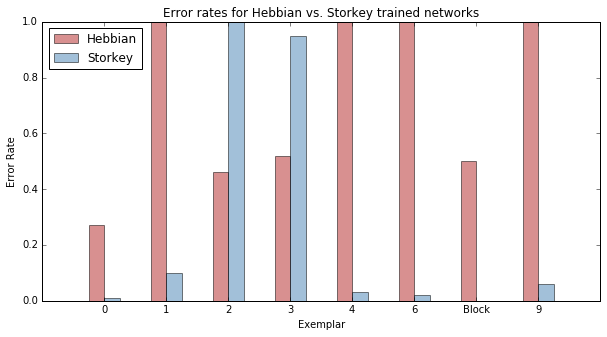

In [7]:
figure = plt.figure(figsize=(10,5))

axes = figure.add_subplot(1,1,1)
axes.set_title("Error rates for Hebbian vs. Storkey trained networks")

exemplars = range(0,8)
width = .25
l1 = axes.bar(exemplars, hebbian_error_rates, -width, color="firebrick", align='edge', alpha=.5)
l2 = axes.bar(exemplars, storkey_error_rates, width, color="steelblue", align='edge', alpha=.5)
axes.set_ylabel("Error Rate")
axes.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
axes.set_xticklabels(['0', '1', '2', '3', '4', '6', 'Block', '9'])
axes.set_xlabel("Exemplar")
axes.legend([l1, l2], ['Hebbian', 'Storkey'], bbox_to_anchor=(.19, 1))


plt.show()

Clearly we've achieved a significant reduction in the mean error rate (72% -> 27%), though not distributed uniformly across the exemplars. The exemplars for 0, 1, 4, 6, block and 9 all show siginificantly improved recall under the Storkey learning rule. However, there is an increase in errors when attempting to recover 2 and 3 (why is this?  An attractor state shared by them under the Hebbian rule?).


----
**Experiment 2:  Saturating a Hopfield Network**

The motivation for Storkey's new learning rule was to determine if the capacity limitations of a Hopfield Network could be improved upon while still retaining the desired learning rule characteristics of locality, incrementality and immediacy.  A Network trained via Hebbian learning will have the absolute capacity of $\frac{n}{(2 \ln{n})}$.  The Storkey Learning Rule can be show analytically to have the absolute capacity $\frac{n}{(\sqrt{2 \ln{n}})}$, which is a significant improvement. Improved network capacity increases the utility of Hopfield networks by consuming less computational resources (memory, processing cycles) for the same number of exemplars - improving the scaling factors  of the network. 

Our second experiment will demonstrate the improvement yielded from the Storkey Learning rule by constructing increasing large Hopfield Networks, training them up to and beyond their maximum capacities while measuring the rate of error when attempting to retrieve exemplars.  The experiment's methodology is as follows:

1. Select a network size _n_, with _n_ starting at 5 and ranging up to 20.
2. Select a number of exemplars _k_, starting at 1 and ranging up to _n-1_.
3. For _k_, run 20 trials wherein:
- Each trial starts with generating _k_ random - though unique - exemplars of length _n. Each random exemplar is a bipolar vector and no two exemplars in a trial are the same.  (_The actual generation process is an implementation detail.  It works by generating all numbers on the range 0 to 2^(n-1), selecting k exemplars without replacement from that population, converting each selected exemplar to a bit vector, finally replacing any 0s with -1s to make it bipolar._ <-- add this to appendix?)
- Train Two Hopfield Networks using the exemplar population:  1 Hebbian & 1 Storkey
- Iterate through the exemplars and impose each upon the networks, recording an error when the recalled exemplar does not match the imposed.
- Calculate the error rate for each network type.
4. After 20 trials, record the mean error rate for that _n,k_.
5. Return to _2_, increasing _k_ while _k <= n - 1_.
6. Return to _1_, increasing _n_ while _n <= 20_.

In [8]:
# Test up to 20 nodes
capacities = {}
results = {}
for n in range(5, 21):
    print "Running experiment for network of size: {0}".format(n)
    for k in range(1, n):

        # 20 trials
        hebbian_error_rates = []
        storkey_error_rates = []
        hebbian_capacity = None
        storkey_capacity = None
        for _ in range(0, 20):
            exemplars = RandomExemplars.get_exemplars(n, k, randomize=True)
            
            # Hebbian network trial
            hebbian_errors = 0
            hebbian_network = HopfieldNetwork(exemplars, learning_rule="Hebb")
            for exemplar in exemplars:
                p = hebbian_network.asynchronous_recall(exemplar)[-1]
                if p != exemplar:
                    hebbian_errors += 1
            
            rate = (1.0 * hebbian_errors)/len(exemplars)
            hebbian_error_rates.append(rate)
            hebbian_capacity = hebbian_network.capacity
            
            #storkey network trial
            storkey_errors = 0
            storkey_network = HopfieldNetwork(exemplars, learning_rule="Storkey")
            for exemplar in exemplars:
                p = storkey_network.asynchronous_recall(exemplar)[-1]
                if p!= exemplar:
                    storkey_errors += 1
                    
            rate = (1.0 * storkey_errors)/len(exemplars)
            storkey_error_rates.append(rate)
            storkey_capacity = storkey_network.capacity
            
        hebbian_error_rate = (1.0 * sum(hebbian_error_rates)) / len(hebbian_error_rates)
        storkey_error_rate = (1.0 * sum(storkey_error_rates)) / len(storkey_error_rates)
        
        # Store capacities
        capacities[n] = {
            'hebbian': hebbian_capacity,
            'storkey': storkey_capacity
        }        
        
        # Store results
        if n not in results:
            results[n] = []
        results[n].append({
                'k': k,
                'hebbian': hebbian_error_rate,
                'storkey': storkey_error_rate
            })

Running experiment for network of size: 5
Running experiment for network of size: 6
Running experiment for network of size: 7
Running experiment for network of size: 8
Running experiment for network of size: 9
Running experiment for network of size: 10
Running experiment for network of size: 11
Running experiment for network of size: 12
Running experiment for network of size: 13
Running experiment for network of size: 14
Running experiment for network of size: 15
Running experiment for network of size: 16
Running experiment for network of size: 17
Running experiment for network of size: 18
Running experiment for network of size: 19
Running experiment for network of size: 20


Charts

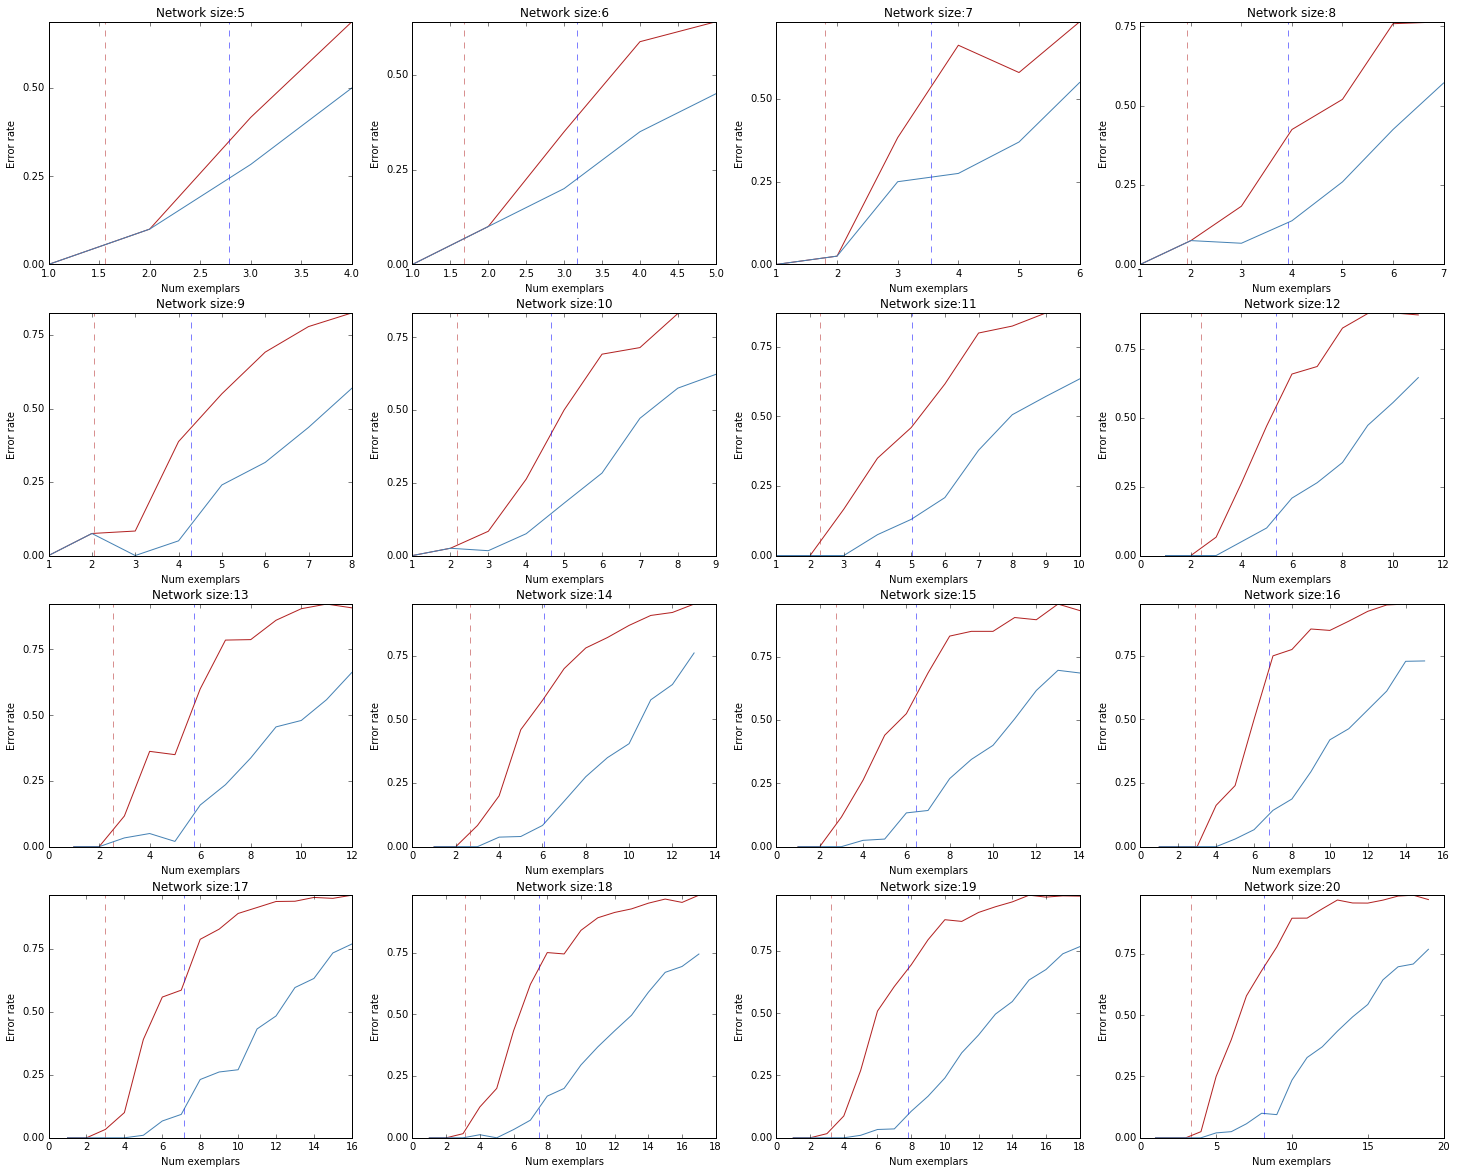

In [10]:
rows = math.sqrt(len(results))
cols = rows

figure = plt.figure(figsize=(25,20))
for i, n in enumerate(results):

    ks = [entry['k'] for entry in results[n]]
    hebbian_rates = [entry['hebbian'] for entry in results[n]]
    storkey_rates = [entry['storkey'] for entry in results[n]]
    
    axes = figure.add_subplot(rows, cols, i+1)
    axes.set_title("Network size:{0}".format(n))
    axes.set_yticks([0, .25, .5, .75, 1])
    axes.set_ylabel("Error rate")
    axes.set_xlabel("Num exemplars")
    
    # Hebbian rule rates & network capacity
    axes.plot(ks, hebbian_rates, color='firebrick', label='Hebbian')
    axes.axvline(x=capacities[n]['hebbian'], color='firebrick', linestyle='--', alpha=.5)
    
    # Storkey rule rates & network capacity
    axes.plot(ks, storkey_rates, color='steelblue', label='Storkey')
    axes.axvline(x=capacities[n]['storkey'], color='blue', linestyle='--', alpha=.5)
    axes.set_title("Network size:{0}".format(n))